# Satellite Earth's outgoing longwave radiation budget intercomparison for climate monitoring

Production date: 29-06-2023

Produced by: CNR-ISMAR, Andrea Storto, Vincenzo de Toma

## Use case: Assessment of different datasets of OLR (outgoing longwave radiation).

## Quality assessment question(s)
* **What are the differences in outgoing longwave radiation among the different products of the ERB dataset?**

**‘Context’** - The OLR products allow quantifying the outgoing longwave radiation for several climate applications. Their temporal coverage and spatial detail varies between the products. There exist offsets between the product, which tend to be significant near the polar regions.

## Quality assessment statement

```{admonition} Key outcomes of this assessment
:class: note
* The OLR products capture the spatial and temporal variability of the outgoing longwave radiation (at the top of the atmosphere) for use in climate analyses, climate model evaluations, and radiative forcing studies.
* The ERB OLR products have different temporal coverage and spatial resolution, namely their combined use is not straightforward and it is recommended for advanced users only, or for selected periods.
* The consistency between the products concerning spatially averaged values is not high, showing systematic offsets between the products, especially for the ESA products.
* Climatological maps and zonally averaged values indicate that the products are sufficiently consistent in most areas, although differences exist and tend to increase near the polar regions.
```

The estimation of outgoing longwave radiation (OLR) at the top of the atmosphere is crucial for understanding the Earth's radiation budget (ERB), which plays a significant role in climate dynamics and energy balance. Despite its importance, accurately assessing OLR-ERB variability using remote sensing data and satellite missions is fraught with challenges due to calibration inconsistencies, data gaps, and the complex interactions of radiation with atmospheric constituents ([[1]](https://doi.org/10.1175/2008JCLI2637.1); 
[[2]](https://doi.org/10.1038/35066553)).

```{figure} attachment:62243d7d-fcc7-4d6e-92db-256602ab2778.png
Zonally averaged outgoing longwave radiation at the top of the atmosphere
```
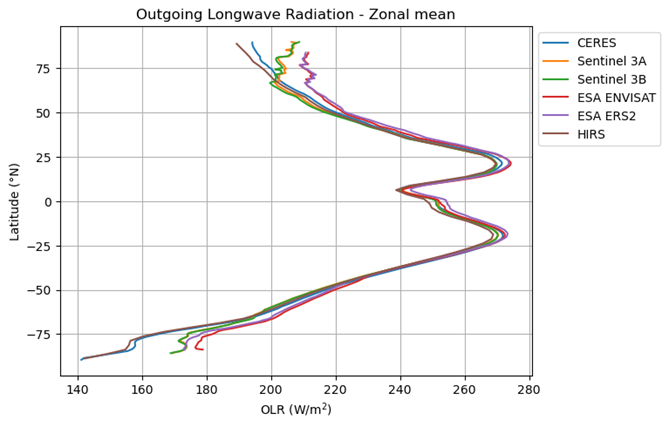

## Methodology

In this notebook we inter-compare the following catalogue entries from the Climate and Atmosphere Data Store (CADS) by Copernicus:
1. CERES Energy Balanced and Filled (EBAF) TOA Monthly means data in netCDF Edition4.1. NASA Langley Atmospheric Science Data Center DAAC (NASA CERES EBAF)
2. NOAA CDR Program, (2018): NOAA Climate Data Record (CDR) of Monthly Outgoing Longwave Radiation (OLR), Version 2.7 (NOAA/NCEI HIRS).
3. Earth's radiation budget from 1979 to present derived from satellite observations. CCI ICDR product version 3.1. Copernicus Climate Change Service Climate Data Store (C3S CCI).
4. ESA Cloud Climate Change Initiative (ESA Cloud_cci) data: Cloud_cci ATSR2-AATSR L3C/L3U CLD_PRODUCTS v3.0 (ESA Cloud CCI).

The analysis and results are organised in the following steps, which are detailed in the sections below:

**1. [Choose the data to use and setup code](choose-the-data-to-use-and-setup-code):**

**2. [Download and Transform](download-and-transform):**

**3. [Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means](plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means):**

 * Plot Spatial weighted time series
 * Time weighted means
 * Spatial weighted Zonal means

## Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Choose the data to use and setup code

In this section, we import the required packages and set up the dataset names for further use in the following sections. Processing functions are also defined.

In [1]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from cartopy import crs as ccrs, feature as cfeature
import cartopy.mpl.ticker as cticker
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
import warnings
warnings.filterwarnings("ignore")

# Variable to analyse
variable = "longwave"
assert variable in ("longwave", "shortwave")

# Region for timeseries
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "northern hemisphere": {"lat_slice": slice(0, 90), "lon_slice": slice(0, 360)},
    "southern hemisphere": {"lat_slice": slice(-90, 0), "lon_slice": slice(0, 360)},
}

collection_id = "satellite-earth-radiation-budget"
chunks = {"year": 1}
varnames = (
    {"olr", "toa_lw_all_mon"} if variable == "longwave" else {"rsf", "toa_sw_all_mon"}
)

collection_id = "satellite-earth-radiation-budget"
chunks = {"year": 1}
varnames = (
    {"olr", "toa_lw_all_mon", "LW_flux"}
    if variable == "longwave"
    else {"rsf", "toa_sw_all_mon", "SW_flux"}
)

request_dict = {
    "CERES": {
        "start": "2000-03",
        "stop": "2024-02",
        "product_family": "ceres_ebaf",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "format": "zip",
        "origin": "nasa",
        "variable": f"outgoing_{variable}_radiation",
    },
    "Sentinel 3A": {
        "start": "2017-01",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3a",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "Sentinel 3B": {
        "start": "2018-10",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3b",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "Sentinel 3A_3B": {
        "start": "2018-10",
        "stop": "2022-06",
        "format": "zip",
        "origin": "c3s",
        "sensor_on_satellite": "slstr_on_sentinel_3a_3b",
        "variable": "all_variables",
        "product_family": "cci",
        "time_aggregation": "monthly_mean",
        "climate_data_record_type": "interim_climate_data_record",
    },
    "ESA ENVISAT": {
        "start": "2002-05",
        "stop": "2012-04",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "sensor_on_satellite": "aatsr",
        "variable": "all_variables",
    },
    "ESA ERS2": {
        "start": "1995-06",
        "stop": "2002-12",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "sensor_on_satellite": "atsr2",
        "variable": "all_variables",
    },
    "HIRS": {
        "start": "1979-01",
        "stop": "2024-04",
        "format": "zip",
        "origin": "noaa_ncei",
        "product_family": "hirs",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
        "version": "2_7_reprocessed",
        "variable": f"outgoing_{variable}_radiation",
    },
    "CLARA_A3": {
        "start": "1979-01",
        "stop": "2020-12",
        "product_family": "clara_a3",
        "origin": "eumetsat",
        "variable": f"outgoing_{variable}_radiation",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
    },
}

def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"])
        ds = ds.assign_coords(time=time)
    return ds


def spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(ds)

xarray_kwargs = {
    "drop_variables": ["time_bounds", "record_status"],
    "preprocess": preprocess_time,
}

(download-and-transform)=
### 2. Download and Transform

The code below will download the products.

In [2]:
da_maps = {}
da_timeseries = {}
for product, request in request_dict.items():
    if product == "HIRS" and variable == "shortwave":
        print(f"{product=} skip")
        continue
    print(f"{product=}")

    start = request.pop("start")
    stop = request.pop("stop")
    requests = download.update_request_date(
        request, start=start, stop=stop, stringify_dates=True
    )

    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=diagnostics.time_weighted_mean,
        chunks=chunks,
        transform_chunks=False,
        **xarray_kwargs,
    )
    (varname,) = set(ds.data_vars) & varnames
    da = ds[varname]
    da.attrs.update({"start": start, "stop": stop})
    da_maps[product] = da

    dataarrays = []
    for region, slices in region_slices.items():
        ds = download.download_and_transform(
            collection_id,
            requests,
            transform_func=spatial_weighted_mean,
            transform_func_kwargs=slices,
            chunks=chunks,
            **xarray_kwargs,
        )
        dataarrays.append(ds[varname].expand_dims(region=[region]))
    da = xr.concat(dataarrays, "region")
    da_timeseries[product] = da

product='CERES'


100%|██████████| 25/25 [00:01<00:00, 17.94it/s]


product='Sentinel 3A'


100%|██████████| 6/6 [00:00<00:00, 20.06it/s]


product='Sentinel 3B'


100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


product='Sentinel 3A_3B'


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


product='ESA ENVISAT'


100%|██████████| 11/11 [00:00<00:00, 21.11it/s]


product='ESA ERS2'


100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


product='HIRS'


100%|██████████| 46/46 [00:02<00:00, 15.76it/s]


product='CLARA_A3'


100%|██████████| 42/42 [00:02<00:00, 18.12it/s]


(plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means)=
### 3. Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means

#### Plot Spatial weighted time series
Below, we calculate and plot spatially weighted means for the different surface radiation budget products. Please note that masks of available data may differ across the products.

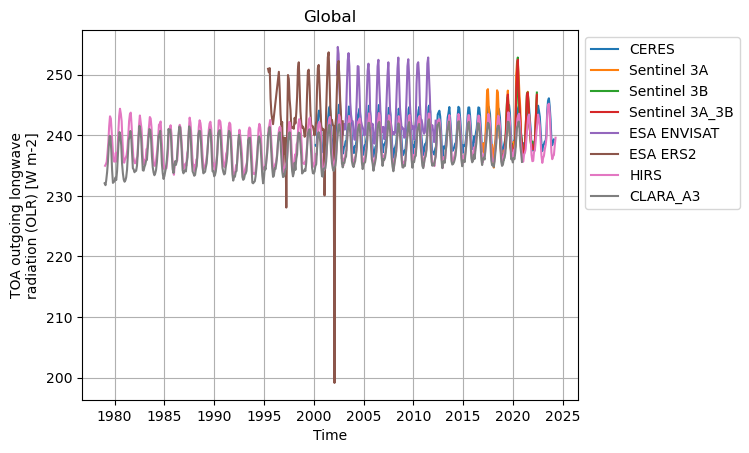

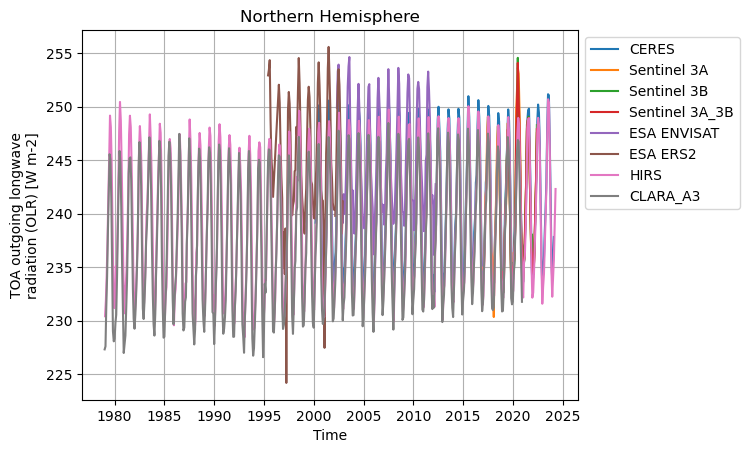

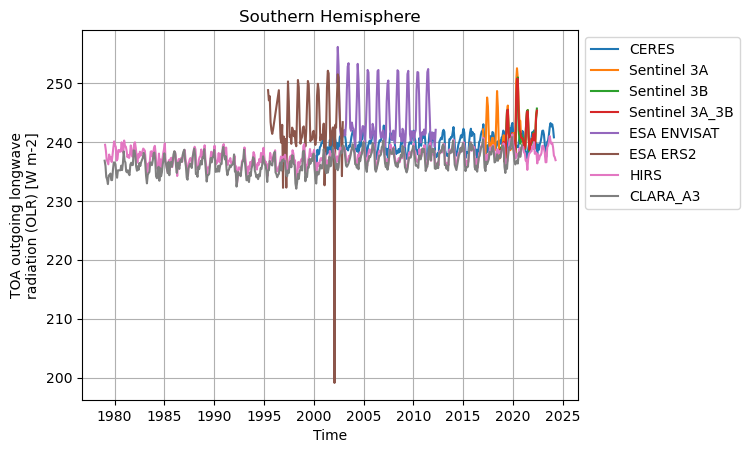

In [3]:
for region in region_slices:
    for product, da in da_timeseries.items():
        da.sel(region=region).plot(label=product)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(region.title())
    plt.grid()
    plt.show()

Timeseries show different temporal sampling for the products, with HIRS covering the longest temporal period. There exist offsest, and the ESA products (ENVISAT, ERS2) are positively biased compared to the other products.

#### Plot Time weighted means
Below, we calculate and plot time-weighted means for the different radiation budget products. Please note that periods differ across the products as shown in the previous section.

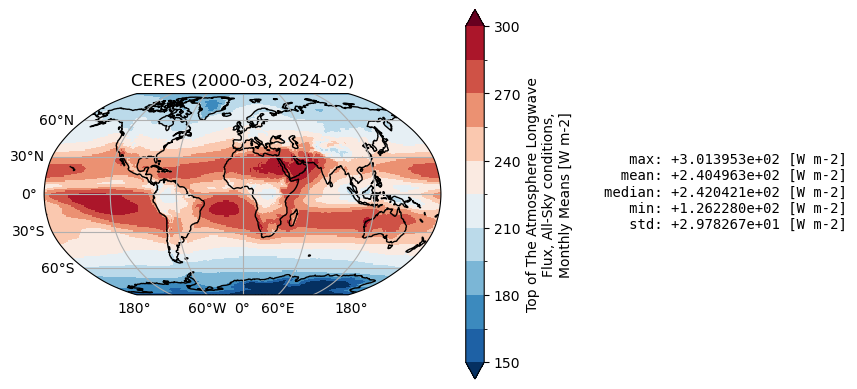

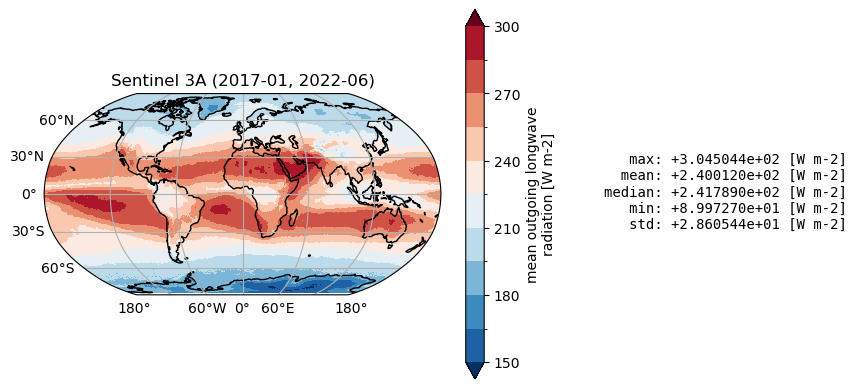

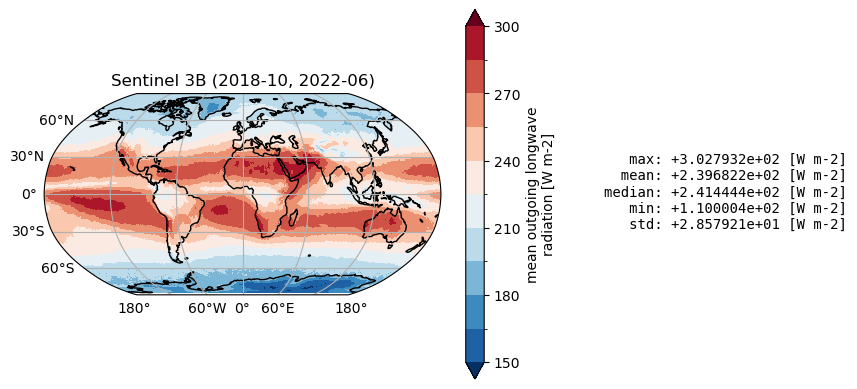

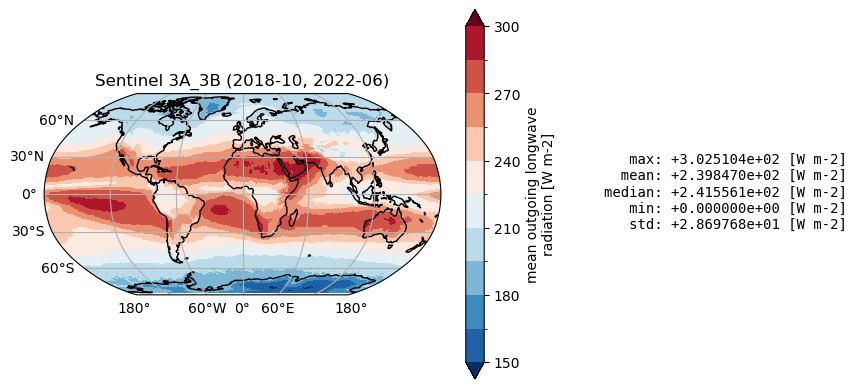

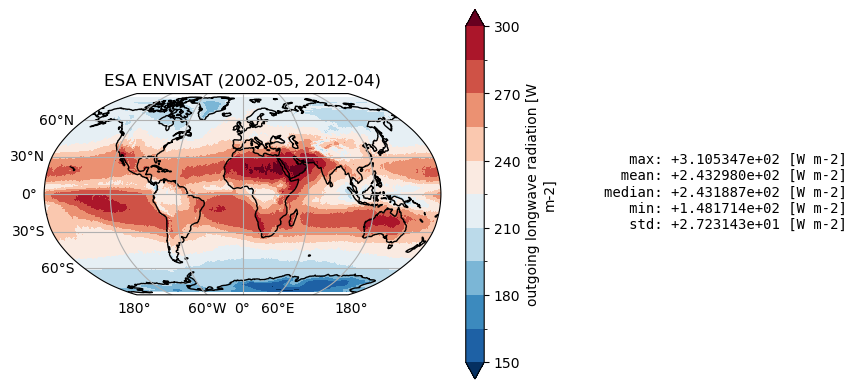

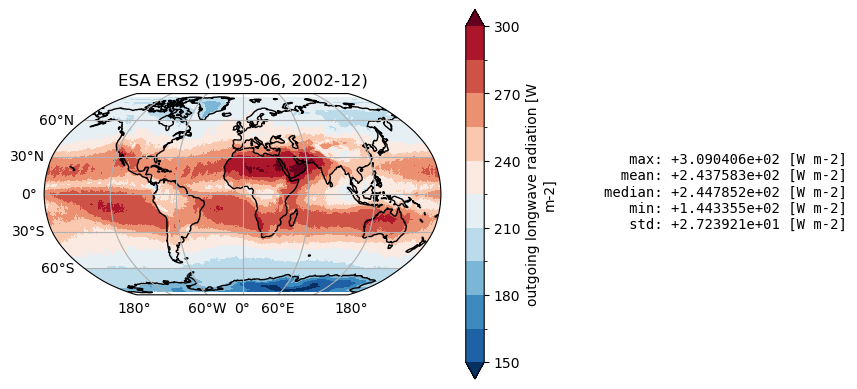

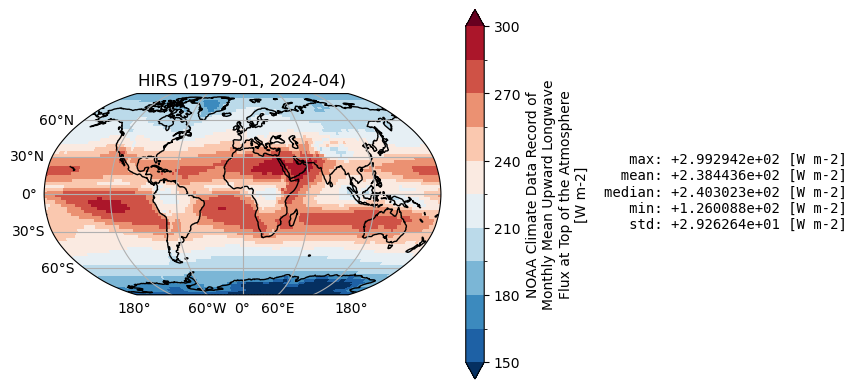

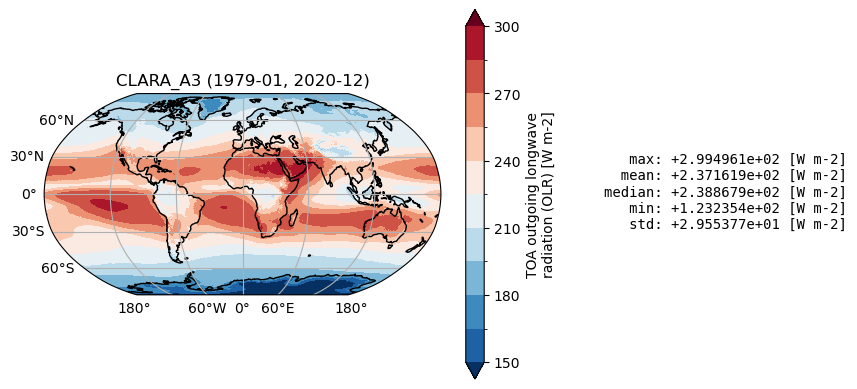

In [4]:
for product, da in da_maps.items():
    plot.projected_map(
        da,
        projection=ccrs.Robinson(),
        levels=range(150, 315, 15) if variable == "longwave" else range(100, 210, 10),
        extend="both",
        cmap="RdBu_r",
    )
    plt.title(f"{product} ({da.attrs['start']}, {da.attrs['stop']})")
    plt.show()

Time mean spatial maps show consisten spatial features across the products, although with significant offsets and difference (e.g. near the Equator, at high latitudes). Differences are also due to varying spatial resolution, and different temporal and spatial sampling across the products.

#### Plot Spatial weighted Zonal means
The code below will calculate and plot weighted zonal means for the radiation budget products. Please note that spatial and temporal sampling may differ across the products.

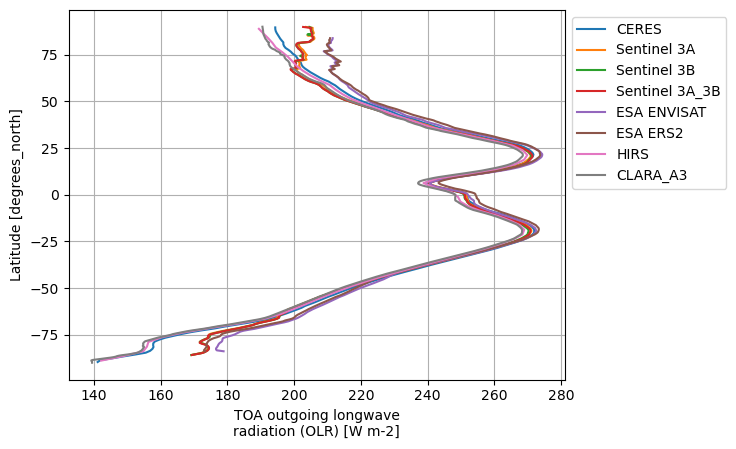

In [5]:
for product, da in da_maps.items():
    da = diagnostics.spatial_weighted_mean(da, dim="longitude")
    da.plot(y="latitude", label=product)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

Zonal averages indicate the good consistency among the products, except at thig latitudes (e.g., south of 50°S and north of 50°N).

## Discussion and applications

Satellite-derived outgoing longwave radiation (OLR) is a valuable metric in climate investigations, providing insights into the Earth's energy balance and temperature distribution. OLR measurements, derived from satellites such as the National Oceanic and Atmospheric Administration's (NOAA) Advanced Very High Resolution Radiometer (AVHRR) and the Atmospheric Infrared Sounder (AIRS) onboard NASA's Aqua satellite, enable researchers to monitor cloud cover, humidity, and the thermal properties of the Earth's surface ([[3]](https://doi.org/10.1029/2012JD017997); [[4]](https://doi.org/10.1073/pnas.1412190111)). By analyzing OLR data over extended periods, scientists can identify trends related to climate change and variability, such as the effects of El Niño and La Niña phenomena on global temperatures ([[5](https://doi.org/10.1002/2017JD027002)). Furthermore, OLR can be used to validate regional climate models and improve predictions of future climate scenarios, thus playing a crucial role in understanding both present conditions and future climate dynamics ([[6]](https://doi.org/10.1175/JCLI3799.1)). 


## If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1175/2008JCLI2637.1) Loeb, N. G., Wielicki, B. A., Doelling, D. R., Smith, G. L., Keyes, D. F., Kato, S., ... & Wong, T. (2009). Toward optimal closure of the Earth's top-of-atmosphere radiation budget. Journal of Climate, 22(3), 748-766

[[2]](https://doi.org/10.1038/35066553) Harries, J. E., Brindley, H. E., Sagoo, P. J., & Bantges, R. J. (2001). Increases in greenhouse forcing inferred from the outgoing longwave radiation spectra of the Earth in 1970 and 1997. Nature, 410(6826), 355-357.

[[3]](https://doi.org/10.1029/2012JD017997) Susskind, J., G. Molnar, L. Iredell, et al., 2012: Interannual variability of outgoing longwave radiation as observed by AIRS and CERES. J. Geophys. Res. Atmos., 117, D23107, doi: 10.1029/2012JD017997.

[[4]](https://doi.org/10.1073/pnas.1412190111) Donohoe, A., Armour, K. C., Pendergrass, A. G., & Battisti, D. S. (2014). Shortwave and longwave radiative contributions to global warming under increasing CO2. Proceedings of the National Academy of Sciences, 111(47), 16700-16705. https://doi.org/10.1073/pnas.1412190111

[[5]](https://doi.org/10.1002/2017JD027002) Su, W., N. G. Loeb, L. Liang, N. Liu, and C. Liu (2017), The El Niño–Southern Oscillation effect on tropical outgoing longwave radiation: A daytime versus nighttime perspective, J. Geophys. Res. Atmos., 122, 7820–7833, https://doi.org/10.1002/2017JD027002.

[[6]](https://doi.org/10.1175/JCLI3799.1) Soden, B. J., and I. M. Held, 2006: An Assessment of Climate Feedbacks in Coupled Ocean–Atmosphere Models. J. Climate, 19, 3354–3360, https://doi.org/10.1175/JCLI3799.1.